# Consistent AI Image Generation

### Project Overview
---
This notebook is part of a multi-part project that compares different approaches to consistent AI image generation.

The methods for consistent AI image generation used are:
- **Method 1:** Image-to-Image Generation Using a Base Image
- **Method 2:** Fine-tuning SD1.5 with similar images until it generates somewhat consistently

You can refer to the [README](https://github.com/angusleung100/AI-Generated-Catgirls-SD) for more background on this project.

### Image-to-Image Generation Using a Base Image
---
SD1.5 has the ability to do Image-to-Image inference, in which a base image is guided by a text prompt to become a new image based on the text prompt. The resulting image should be very similar to the original image and keep most of its details. For example, a picture of a dog running should in theory keep the original dog.


In [ ]:
# Import prequisites
!pip install diffusers transformers accelerate torch numpy safetensors IPython

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.1/314.1 kB 26.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylin

In [ ]:
# Import prerequisites
import os
import torch
import numpy as np

from transformers import AutoConfig, AutoModel
from diffusers import StableDiffusionPipeline, StableDiffusionImg2ImgPipeline, DDIMScheduler, LMSDiscreteScheduler, PNDMScheduler, EulerAncestralDiscreteScheduler, EulerDiscreteScheduler, DPMSolverMultistepScheduler
from diffusers.utils import load_image, make_image_grid
from safetensors.torch import load_file
from IPython.display import Image, display
from PIL import Image
from google.colab import userdata, drive

In [ ]:
# Script Configuration
drive.mount('/content/drive', force_remount=True)

base_directory = "/content/drive/My Drive/AI Consistent Generation/"

civitai_token = ""  # Civitai API token

hf_token = userdata.get('hf_token') # Hugging Face auth token read/write

# Load a checkpoint downloaded from Civitai (brav5 or brav7)
base_checkpoint = "brav7"

# Load a checkpoint from Hugging Face
#base_checkpoint = "https://huggingface.co/WarriorMama777/OrangeMixs/blob/main/Models/AbyssOrangeMix/AbyssOrangeMix.safetensors" # From model link
#base_checkpoint = "runwayml/stable-diffusion-v1-5" # From model name


Mounted at /content/drive


In [ ]:
# Download checkpoint from Civitai

!curl -L -o brav7.safetensors https://civitai.com/api/download/models/177164  # BRA V7
#!curl -L -o brav5.safetensors https://civitai.com/api/download/models/63786  # BRA V5

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   510    0   510    0     0   1181      0 --:--:-- --:--:-- --:--:--  1180
100 2033M  100 2033M    0     0  37.9M      0  0:00:53  0:00:53 --:--:-- 31.1M


### Load Base Model
---

In [ ]:
# Load weights from Hugging Face
#pipeline = StableDiffusionPipeline.from_single_file(base_checkpoint, token=hf_token)

# Load weights from Civitai
pipeline = StableDiffusionPipeline.from_single_file(base_checkpoint+".safetensors", token=hf_token, use_safetensors=True, torch_dtype=torch.float16, local_files_only=True)

# Move the pipeline to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pipeline.to(device)

`local_files_only` is True but no local configs were found for this checkpoint.
Attempting to download the necessary config files for this pipeline.



Fetching 11 files:   0%|          | 0/11 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Some weights of the model checkpoint were not used when initializing CLIPTextModel: 
 ['text_model.embeddings.position_ids']
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.29.2",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

### Load Textual Inversions
---

In [ ]:
# Bad anatomy
!curl -L -o bad_NegAnatomy.pt https://civitai.com/api/download/models/64063 # https://civitai.com/models/59614/badneganatomy-textual-inversion
!curl -L -o Deep_NegativeV1.pt https://civitai.com/api/download/models/5637 # https://civitai.com/models/4629/deep-negative-v1x
!curl -L -o Bad_Hands4.pt https://civitai.com/api/download/models/20068 # https://civitai.com/models/16993/badhandv4

textual_inversions = ['bad_NegAnatomy.pt', 'Deep_NegativeV1.pt', 'Bad_Hands4.pt']

for ti in textual_inversions:
  pipeline.load_textual_inversion(ti, local_files_only=True)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   488    0   488    0     0   1850      0 --:--:-- --:--:-- --:--:--  1855
100  210k  100  210k    0     0   380k      0 --:--:-- --:--:-- --:--:--  380k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   494    0   494    0     0    929      0 --:--:-- --:--:-- --:--:--   928
100  225k  100  225k    0     0   268k      0 --:--:-- --:--:-- --:--:--  268k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   472    0   472    0     0    892      0 --:--:-- --:--:-- --:--:--   890
100 19371  100 19371    0     0  23513      0 --:--:-- --:--:-- --:--:-- 23513


### Generation Config
---

In [ ]:
config = {
  'num_inference_steps': 20,
  'strength': 0.8,
  'guidance_scale': 7,
  'num_images_per_prompt': 5, # Max images per prompt for T4 is around 5-10
  'height': 512,
  'width': 512,
  'cfg_scale': 12,
  'seed': 550197436,
  'scheduler': "DPMSolverMultistepScheduler"
}

torch.manual_seed(config['seed'])

positive_prompt = """masterpiece, best quality, 8k, highres, portrait shot, shiny skin, super detailed skin, white dress, white patterned dress, looking at camera, full body portrait, standing in busy street, blurred background, detailed beautiful face and eyes, Korean girl, kpop idol, professional lighting, realistic, (long hair, black hair, brown eyes)"""

negative_prompt = """watermark, logo, paintings, sketches, (worst quality:2), (low quality:2), (normal quality:2), lowres, normal quality, ((monochrome)), ((grayscale)), bad-hands-5 easynegative verybadimagenegative_v1.3"""

### Generation function
---

In [ ]:
def generate(config, base_image, positive_prompt, negative_prompt):

  # Load scheduler
  if config['scheduler'] == "DDIMScheduler":
    pipeline.scheduler = DDIMScheduler.from_config(pipeline.scheduler.config)
  elif config['scheduler'] == "LMSDiscreteScheduler":
    pipeline.scheduler = LMSDiscreteScheduler.from_config(pipeline.scheduler.config)
  elif config['scheduler'] == "EulerAncestralDiscreteScheduler":
    pipeline.scheduler = EulerAncestralDiscreteScheduler.from_config(pipeline.scheduler.config)
  elif config['scheduler'] == "EulerDiscreteScheduler":
    pipeline.scheduler = EulerDiscreteScheduler.from_config(pipeline.scheduler.config)
  elif config['scheduler'] == "DPMSolverMultistepScheduler":
    pipeline.scheduler = DPMSolverMultistepScheduler.from_config(pipeline.scheduler.config)
  else:
    pipeline.scheduler = PNDMScheduler.from_config(pipeline.scheduler.config)

    # Note: By default it is PNDMS scheduler
  return pipeline(prompt=positive_prompt, negative_prompt=negative_prompt, init_image=base_image, width=config['width'], height=config['height'], num_images_per_prompt=config['num_images_per_prompt'], num_inference_steps=config['num_inference_steps'], strength=config['strength'], guidance_scale=config['guidance_scale'])

### Bulk Image Generation Script


In [ ]:
# Set save directory

save_directory = "2024-07-15"  # Check before change to avoid overwriting existing images

if not os.path.exists(base_directory+save_directory):  # Make directory if not exists
  os.makedirs(base_directory+save_directory)
  print('Created save directory')

Created save directory


In [ ]:
batch_img_count = 0 # Current label for number in a batch DO NOT EDIT

batch_count = 1 # Current batches to generate

print("Total Generated Images: ", str(config['num_images_per_prompt']*batch_count))


# Generate multiple batches

for i in range(batch_count):  # Batch
  print("Generating Batch ", str(i))

  result = generate(config, None, positive_prompt, negative_prompt)

  for img in result.images:

    img.save(base_directory+save_directory+"/"+"base_image_"+str(i)+"_"+str(batch_img_count)+".png")
    batch_img_count += 1

  batch_img_count = 0


Total Generated Images:  5
Generating Batch  0


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


### Save Generation Settings For Session
---

In [ ]:
try:

  with open(base_directory+save_directory+"/generation_settings.txt", "x") as f:
    f.write("Seed: "+str(config['seed'])+"\nPositive Prompt: "+positive_prompt+"\nNegative Prompt: "+negative_prompt+"\n")
    f.write("Base Image: "+str(None)+"\nNum Inference Steps: "+str(config['num_inference_steps'])+"\nStrength: "+str(config['strength'])+"\n")
    f.write("Images Per Batch: "+str(config['num_images_per_prompt'])+"\nNumber of Batches: "+str(batch_count)+"\nTotal Images: "+str(config['num_images_per_prompt']*batch_count)+"\n")
    f.write("Guidance Scale: "+str(config['guidance_scale'])+"\nTextual Inversions Used: "+str(textual_inversions)+"\nScheduler Used: "+str(config['scheduler'])+"\n")

except:
    with open(base_directory+save_directory+"/generation_settings.txt", "w") as f:
      f.write("Seed: "+str(config['seed'])+"\nPositive Prompt: "+positive_prompt+"\nNegative Prompt: "+negative_prompt+"\n")
      f.write("Base Image: "+str(None)+"\nNum Inference Steps: "+str(config['num_inference_steps'])+"\nStrength: "+str(config['strength'])+"\n")
      f.write("Images Per Batch: "+str(config['num_images_per_prompt'])+"\nNumber of Batches: "+str(batch_count)+"\nTotal Images: "+str(config['num_images_per_prompt']*batch_count)+"\n")
      f.write("Guidance Scale: "+str(config['guidance_scale'])+"\nTextual Inversions Used: "+str(textual_inversions)+"\nScheduler Used: "+str(config['scheduler'])+"\n")

### Display Generated Images
---

We review the generated images and generate more until we are satisfied with an image to be used as the "base image".

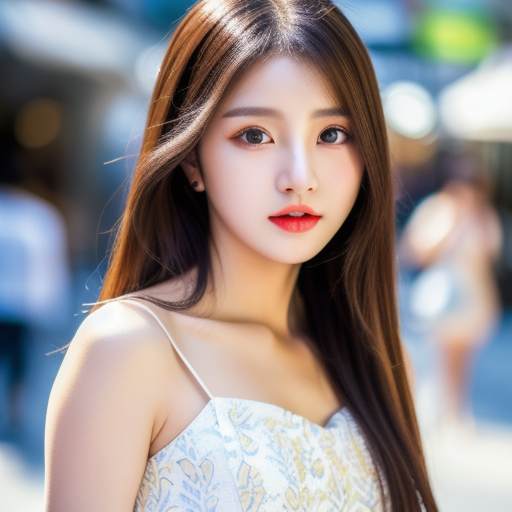

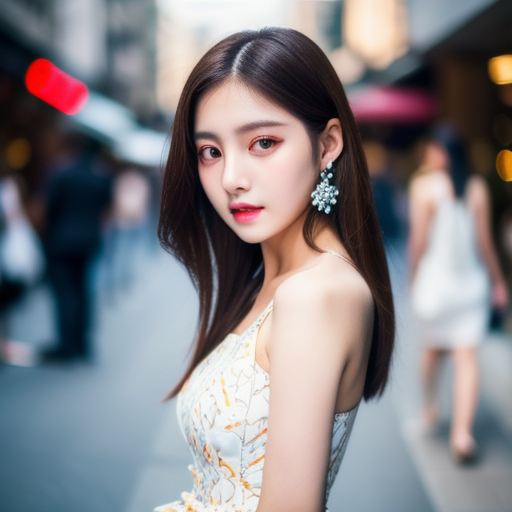

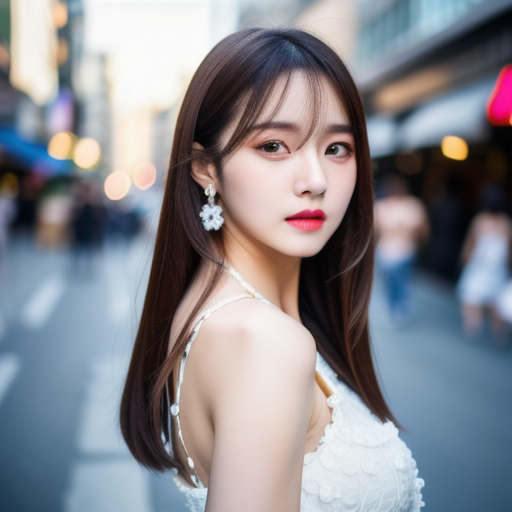

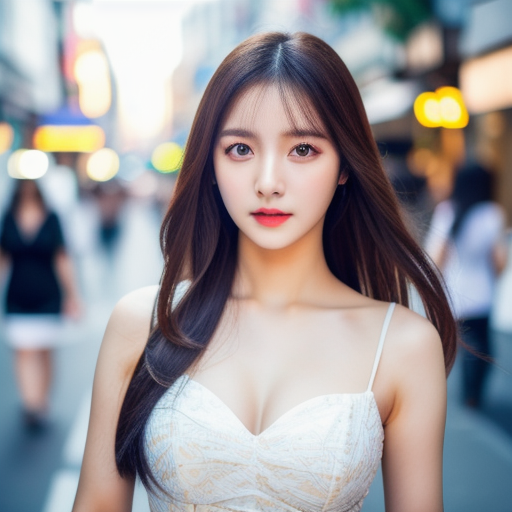

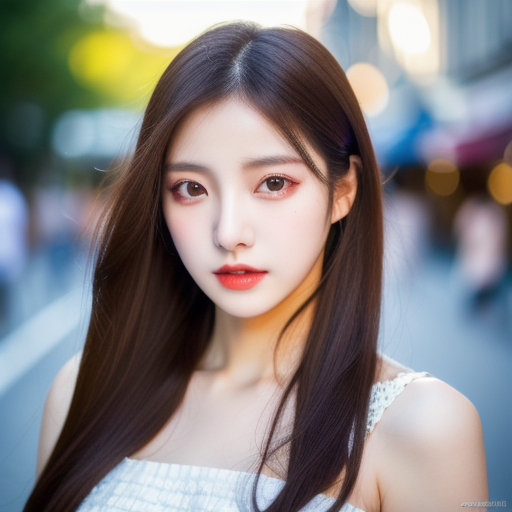

In [ ]:
image_names = os.listdir(base_directory+save_directory)

number_to_display = 5 # Number of images to display

img_num = 0

for img in image_names:

  if img_num == number_to_display:
    break

  if ".txt" in img:
    continue
  else:
    display(Image.open(str(base_directory+save_directory+"/"+img)))
    img_num += 1

# Single Base Image IMG2IMG
---

A high-quality image is selected from the generated batches to be used as the "base image" for image-to-image generation.

The Stable Diffusion Img2Img pipeline has to be loaded as well to use img2img.

In [ ]:
# Create pipeline for img2img generation

# Load weights from Civitai
img2imgpipeline = StableDiffusionImg2ImgPipeline.from_single_file(base_checkpoint+".safetensors", token=hf_token, use_safetensors=True, torch_dtype=torch.float16, local_files_only=True)

# Move the pipeline to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
img2imgpipeline.to(device)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Some weights of the model checkpoint were not used when initializing CLIPTextModel: 
 ['text_model.embeddings.position_ids']
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_img2img.StableDiffusionImg2ImgPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


StableDiffusionImg2ImgPipeline {
  "_class_name": "StableDiffusionImg2ImgPipeline",
  "_diffusers_version": "0.29.2",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [ ]:
# Generate images based on a single base image

# Base image selected
base_image = load_image(base_directory+"/"+"base_image.png")

print(type(base_image))

config = {
  'num_inference_steps': 20,
  'strength': 0.8,
  'guidance_scale': 7,
  'num_images_per_prompt': 1,
  'height': 512,
  'width': 512,
  'batch_size': 5,
  'cfg_scale': 12,
  'seed': 550197436,
  'scheduler': "DPMSolverMultistepScheduler"
}

torch.manual_seed(config['seed'])

<class 'PIL.Image.Image'>


After sorting through the generated images, we found the one we consider a good candidate and pass it into the pipeline as the initial image.

We also try to keep the same configuration across the the base image generation and the img2img generation to keep consistency in the generated image style and characters generated.

In [ ]:
# Generation function
def img2img_generation(config, base_image, positive_prompt, negative_prompt):

  # Load scheduler
  if config['scheduler'] == "DDIMScheduler":
    img2imgpipeline.scheduler = DDIMScheduler.from_config(img2imgpipeline.scheduler.config)
  elif config['scheduler'] == "LMSDiscreteScheduler":
    img2imgpipeline.scheduler = LMSDiscreteScheduler.from_config(img2imgpipeline.scheduler.config)
  elif config['scheduler'] == "EulerAncestralDiscreteScheduler":
    img2imgpipeline.scheduler = EulerAncestralDiscreteScheduler.from_config(img2imgpipeline.scheduler.config)
  elif config['scheduler'] == "EulerDiscreteScheduler":
    img2imgpipeline.scheduler = EulerDiscreteScheduler.from_config(img2imgpipeline.scheduler.config)
  elif config['scheduler'] == "DPMSolverMultistepScheduler":
    img2imgpipeline.scheduler = DPMSolverMultistepScheduler.from_config(img2imgpipeline.scheduler.config)
  else:
    img2imgpipeline.scheduler = PNDMScheduler.from_config(img2imgpipeline.scheduler.config)

    # Note: By default it is PNDMS scheduler
  return img2imgpipeline(prompt=positive_prompt, negative_prompt=negative_prompt, image=base_image, width=config['width'], height=config['height'], num_images_per_prompt=config['batch_size'], num_inference_steps=config['num_inference_steps'], strength=config['strength'], guidance_scale=config['guidance_scale'])

### Generate Image From Base Image
---
A new image is generated using the base image and a new prompt to guide the model.

In [ ]:
modification_prompt = "Korean kpop idol standing in a busy street in Causeway Bay at night"
negative_prompt = """watermark, logo, paintings, sketches, (worst quality:2), (low quality:2), (normal quality:2), lowres, normal quality, ((monochrome)), ((grayscale)), bad-hands-5 easynegative verybadimagenegative_v1.3"""

result = img2img_generation(config, base_image, modification_prompt, negative_prompt)

result.images[0].save(base_directory+"/"+"altered_image.png")

/usr/local/lib/python3.10/dist-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion_img2img.py:767: FutureWarning: You have passed 5 text prompts (`prompt`), but only 1 initial images (`image`). Initial images are now duplicating to match the number of text prompts. Note that this behavior is deprecated and will be removed in a version 1.0.0. Please make sure to update your script to pass as many initial images as text prompts to suppress this warning.
  deprecate("len(prompt) != len(image)", "1.0.0", deprecation_message, standard_warn=False)


  0%|          | 0/16 [00:00<?, ?it/s]

### Display Generated Image
---

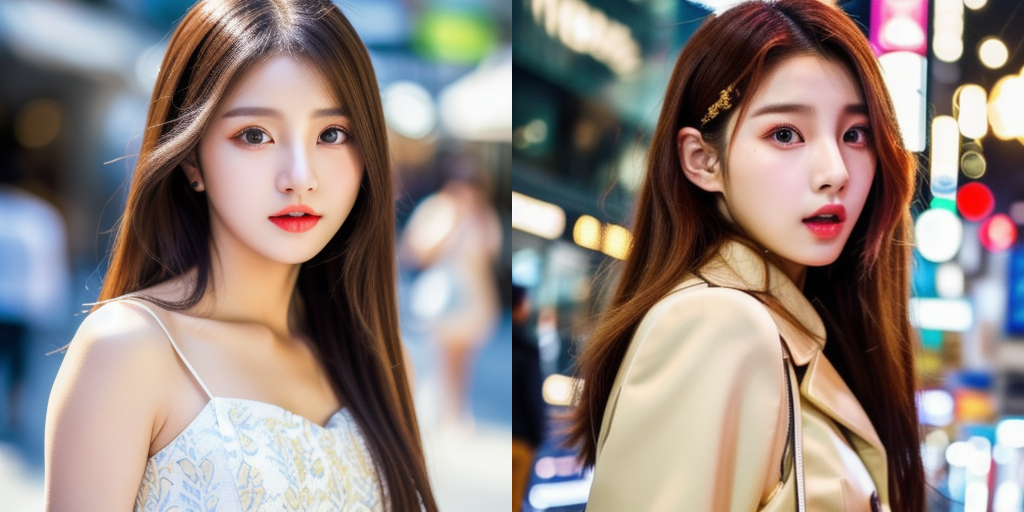

In [ ]:
make_image_grid([base_image, Image.open(base_directory+"/"+"altered_image.png")], rows=1, cols=2)

Overall the image-to-image generation was pretty good. However, if the generated image does not look similar or the same as the base image, you could always regenerate a few times to pick out the best image.

### Generate Several More Images From Base Image
---
Below we generate more images to compare with the base image and to pick from.

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

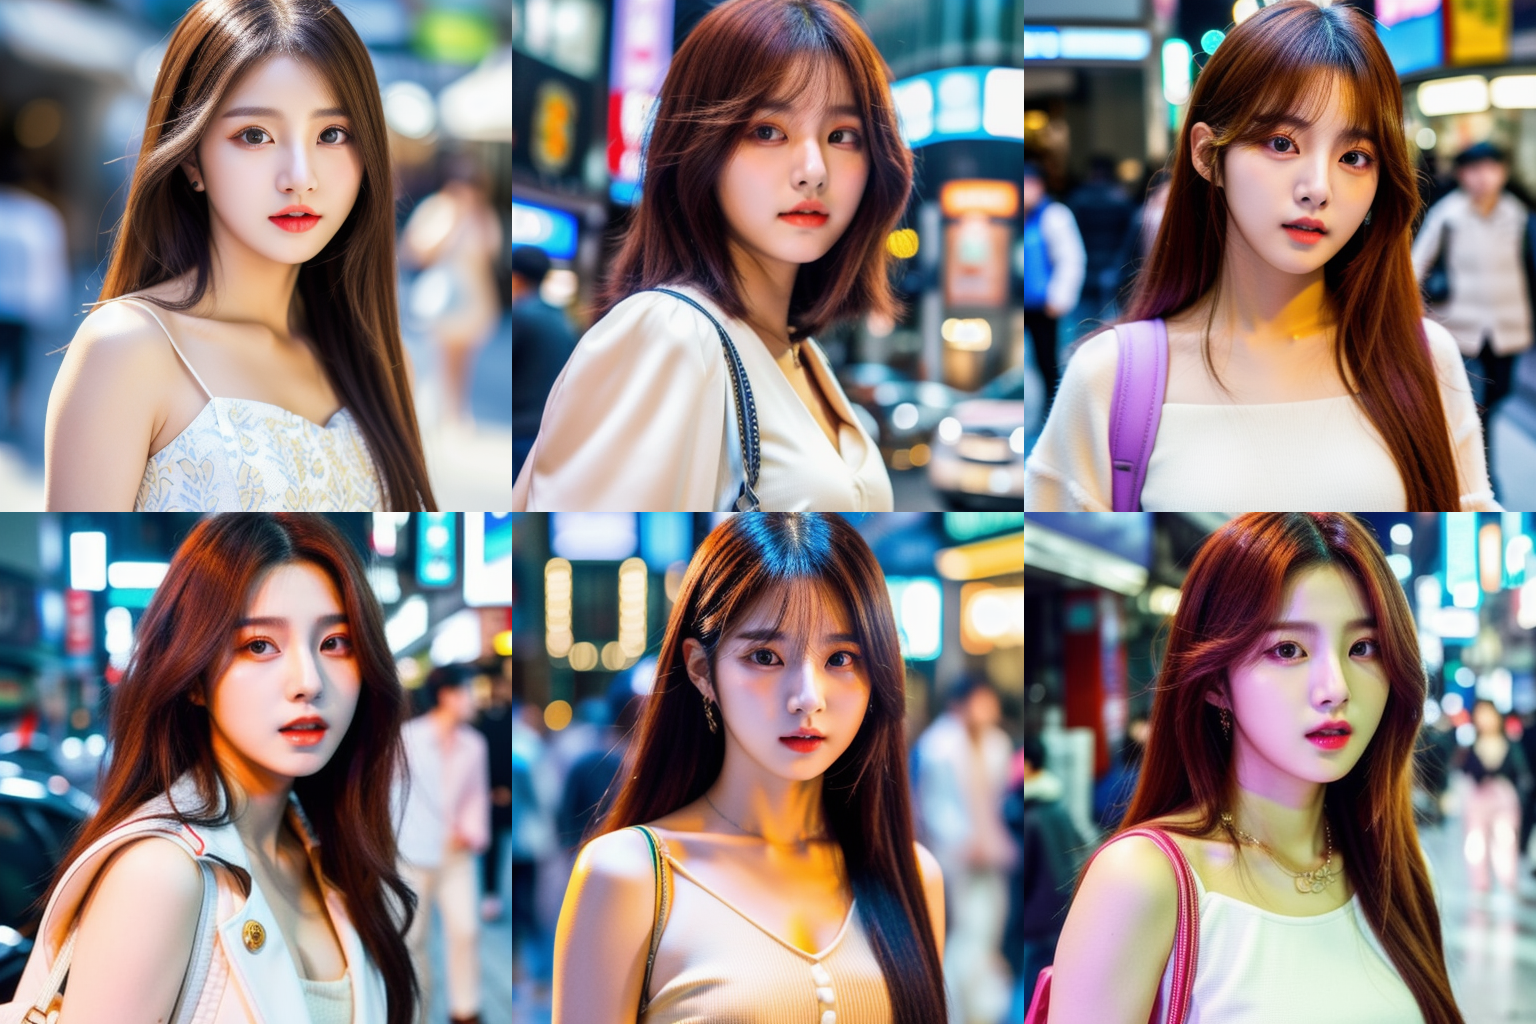

In [ ]:
num_images = 5 # Number of images to generate from img2img

for i in range(num_images):
  result = img2img_generation(config, base_image, modification_prompt, negative_prompt)

  result.images[0].save(base_directory+"/"+"altered_image_"+str(i)+".png")

img2img_images = [base_image]

for i in range(num_images):
  img2img_images.append(Image.open(base_directory+"/"+"altered_image_"+str(i)+".png"))

make_image_grid(img2img_images, rows=2, cols=3)